# HSF Uproot Tutorial Lecture Notebook

## Introduction

- Uproot is a Scikit-HEP package which offers tools to read and write `.root` files without the use of ROOT.
- In this session, we will be learning about this useful package by going through the [HSF Uproot Tutorial](https://masonproffitt.github.io/uproot-tutorial/).
- This notebook is meant to summarize the material found in the afformentioned tutorial, while expanding on some points not emphasized there, and can be used as a quick reference or to follow along during the session. 
- For a more complete description of Uproot and other Scikit-HEP packages, please visit the [Scikit-HEP Project Website](https://scikit-hep.org/)

## ROOT?
- Root is a specialized data format designed to store large amounts of data in a structured way.
- They can contain a variety of data types such as histograms.
- One of the key features of a root file is the TTree structure in which each entry represents an event and each branch various pieces of data associated with said event.

## Jagged arrays
- In HEP, you might events with different number of the same particle. This means that the length of object collections (e.g. $p_T$ of detected muons) is not constant. In order to deal with this type of data, we use jagged arrays.
- Awkward Array is a library for using nested, variable-sized data with a Numpy-like syntax. This is one of the most important dependencies of Uproot, as it allows us to load jagged arrays from root files, and manipulate them using Awkward.

In [2]:
import numpy as np
import awkward as ak

In [2]:
# Numpy arrays NEED to be homogeneous.
numpy_inh_arr = np.array([
    [1, 2, 3],
    [1, 2],
    [1, 3, 4, 5]
])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [3]:
awk_arr = ak.Array([
    [1, 2, 3],
    [1, 2],
    [1, 3, 4, 5]
])

In [4]:
ak.sum(awk_arr, axis=1)

<Array [6, 3, 13] type='3 * int64'>

## Opening Files
- We will be using an `root` file which contains real CMS data of pp collisions in 2012.

In [4]:
# Run this cell to import Uproot
import uproot

In [6]:
# Run this cell to download the data if you haven't already.
! wget https://github.com/masonproffitt/uproot-tutorial-notebooks/raw/master/uproot-tutorial-file.root .

--2024-04-03 13:23:04--  https://github.com/masonproffitt/uproot-tutorial-notebooks/raw/master/uproot-tutorial-file.root
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/masonproffitt/uproot-tutorial-notebooks/master/uproot-tutorial-file.root [following]
--2024-04-03 13:23:05--  https://raw.githubusercontent.com/masonproffitt/uproot-tutorial-notebooks/master/uproot-tutorial-file.root
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3568384 (3.4M) [application/octet-stream]
Saving to: ‘uproot-tutorial-file.root.1’

uproot-tutorial-fil 100%[===================>]   3.40M  3.99MB/s    in 0.9s    

202

In [5]:
# Opening the root file
file = uproot.open("./uproot-tutorial-file.root")
file

<ReadOnlyDirectory '/' at 0x000126cd9700>

- Root files contents are structured in a way reminiscent of a small filesystem with directories and nested directories. We can check the name of the contents at the upper-most level of this "directory" structure.
- Notice that the syntax used here is similar to that of dictionaries.

![roottree](./assets/roottree.png)

In [8]:
# Checking the name of the contents
file.keys()

['Events;1']

In [9]:
# We can also check the type of each of the contents
file.classnames()

{'Events;1': 'TTree'}

- A TTree is is a class which stores data in a way similar to Pandas DataFrames. Each "column" is a TBranch and it can contain objects of any C++ type.
- In the cell below, notice that each the `Events` TTree has 6 branches.

In [10]:
# We can access the TTree like this
file["Events"]

<TTree 'Events' (6 branches) at 0x0001159110a0>

- We can access the contents of this TTree the following way. When we do, we can see the name of each branch, which describes what content each branch has. 

In [6]:
tree = file["Events"]
tree.keys()

['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']

- To emphasize the point about TTrees having a similar structure to Pandas DataFrames, notice that, with a little bit of work, the data can be transformed into a DataFrame.

In [12]:
import pandas as pd

treedf = pd.DataFrame()
for branch in tree.keys():
    treedf[branch] = pd.Series(tree[branch].array(library="np"))
treedf.reset_index(inplace=True)
treedf.rename({"index": "Event"}, axis="columns", inplace=True)
treedf

,Event,nMuon,Muon_pt,Muon_eta,Muon_phi,Muon_mass,Muon_charge
0,0,2,"[10.763697, 15.736523]","[1.0668273, -0.5637865]","[-0.034272723, 2.5426154]","[0.10565837, 0.10565837]","[-1, -1]"
1,1,2,"[10.53849, 16.327097]","[-0.42778006, 0.34922507]","[-0.2747921, 2.5397813]","[0.10565837, 0.10565837]","[1, -1]"
2,2,1,[3.2753265],[2.2108555],[-1.2234136],[0.10565837],[1]
3,3,4,"[11.429154, 17.634033, 9.624728, 3.5022252]","[-1.5882396, -1.7511845, -1.590997, -1.6559632]","[-2.0773041, 0.25135836, -2.0130494, -1.8499726]","[0.10565837, 0.10565837, 0.10565837, 0.10565837]","[1, 1, 1, 1]"
4,4,4,"[3.2834418, 3.6440058, 32.911224, 23.721754]","[-2.1724837, -2.182535, -1.1233627, -1.1629014]","[-2.3700082, -2.305139, -0.9752425, -0.77300525]","[0.10565837, 0.10565837, 0.10565837, 0.10565837]","[-1, -1, 1, 1]"
...,...,...,...,...,...,...,...
99995,99995,3,"[30.298992, 9.889153, 6.6907263]","[0.26223773, -0.58793086, 0.31247106]","[1.2456522, 0.815711, 1.663327]","[0.10565837, 0.10565837, 0.10565837]","[1, 1, 1]"
99996,99996,2,"[46.36219, 43.90394]","[-1.928397, -2.273382]","[-2.3772607, 0.86048985]","[0.10565837, 0.10565837]","[-1, 1]"
99997,99997,3,"[6.343258, 6.9803934, 5.0852466]","[-0.59949154, -0.0495256, -0.9052992]","[-2.9530895, 0.26560423, -3.1138406]","[0.10565837, 0.10565837, 0.10565837]","[-1, 1, 1]"
99998,99998,2,"[3.3099499, 15.68049]","[1.6359439, 0.4766063]","[0.87988055, -1.7524908]","[0.10565837, 0.10565837]","[1, -1]"


- Of course, this is not a good way to handle this sort of data. This is just for pedagogical purposes.
- In order to convert the data in one of the branches to an array, we would do something like the following.

In [7]:
branches = tree.arrays()
branches

<Array [{nMuon: 2, Muon_pt: [...], ...}, ...] type='100000 * {nMuon: uint32...'>

- To access the branches, we can use syntax identical to that of Python dictionaries.

In [17]:
# Jagged array
branches["Muon_pt"]

<Array [[10.8, 15.7], ..., [11.4, ..., 4.97]] type='100000 * var * float32'>

In [18]:
# Array
branches["nMuon"]

<Array [2, 2, 1, 4, 4, 3, 2, ..., 1, 0, 3, 2, 3, 2, 3] type='100000 * uint32'>

- There are multiple ways we can slides our data, depending on what we're trying to do. Here are some example.

In [19]:
# Pt of muons in the 0'th event
print(branches[["Muon_pt", "nMuon"]][0])
# All information of event 0
print(branches[0])
# For events from 10 to 14, the number of muons.
print(branches[10:15]["nMuon"])

{Muon_pt: [10.8, 15.7], nMuon: 2}
{nMuon: 2, Muon_pt: [10.8, 15.7], Muon_eta: [1.07, ...], Muon_phi: [...], ...}
[2, 2, 6, 3, 2]


**Exercise**: 
Print out the pt and charge of the muons from events 100 to 115.

In [20]:
# Put your answer here
branches[100:116][["Muon_pt", "Muon_charge"]]

<Array [{Muon_pt: [...], ...}, ..., {...}] type='16 * {Muon_pt: var * float...'>

## Histograms
- Histograms are one of the most important tools in HEP. They describe the frequency distributions of a set of data points by dividing the entire range of values into a series of "bin" and counting how many data points fall into each interval.
- Scikit-HEP offers us some toosl for histograming, but for now we will be using Matplotlib.

In [3]:
import matplotlib.pyplot as plt

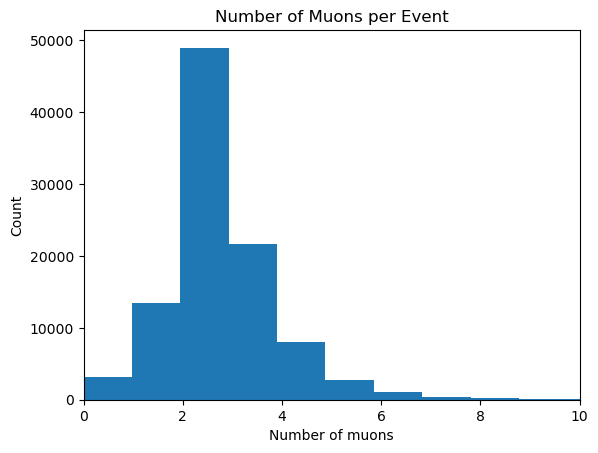

In [22]:
# Doc: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(
    branches["nMuon"], 
    bins=40
    # bins=np.arange(50)
)

plt.title("Number of Muons per Event")
plt.xlim((0, 10))
plt.ylabel("Count")
plt.xlabel("Number of muons")
plt.show()

[3.21e+03, 1.34e+04, 4.9e+04, 2.17e+04, 8.02e+03, 2.75e+03, ..., 0, 0, 0, 0, 1]
[0, 0.975, 1.95, 2.92, 3.9, 4.88, 5.85, ..., 33.1, 34.1, 35.1, 36.1, 37, 38, 39]


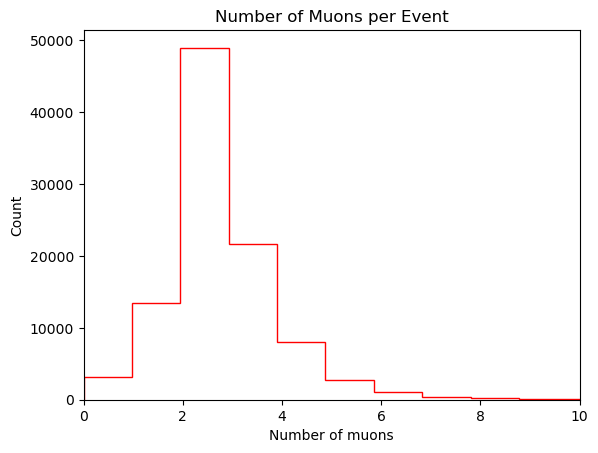

In [23]:
# Note that if the data has already been binned and counted, it might be better to use plt.stairs
# Doc: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.stairs.html
counts, bins = np.histogram(
    branches["nMuon"], 
    bins=40,
    # bins=np.arange(40)
)
print(counts)
print(bins)

plt.stairs(
    counts, 
    bins,
    color="red"
)
plt.title("Number of Muons per Event")
plt.xlim((0, 10))
plt.ylabel("Count")
plt.xlabel("Number of muons")
plt.show()
plt.show()

- If the histograms we are trying to make is in the form of a jagged array, we would need to flatten it first.

In [24]:
ak.flatten(branches["Muon_pt"])


<Array [10.8, 15.7, 10.5, 16.3, ..., 11.4, 3.08, 4.97] type='235286 * float32'>

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/var/folders/t8/8pnmh4rj2lbbd7gfq8tf09180000gn/T/ipykernel_31287/872760970.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')


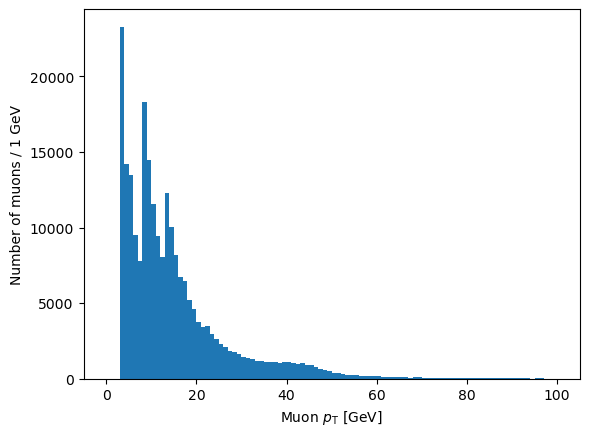

In [27]:
plt.hist(
    ak.flatten(branches["Muon_pt"]),
    bins=100,
    range=(0,100)
)
plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of muons / 1 GeV')
# Sometimes it might be a bit more insightful to use logarithmic axis.
# plt.yscale('log')
plt.show()

- One issue with logarithmic scales if applied to the x-axis is that the bin size is not made logarithmic as well. This produces weird looking plots like the one shown below.

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/var/folders/t8/8pnmh4rj2lbbd7gfq8tf09180000gn/T/ipykernel_31287/2886826615.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')


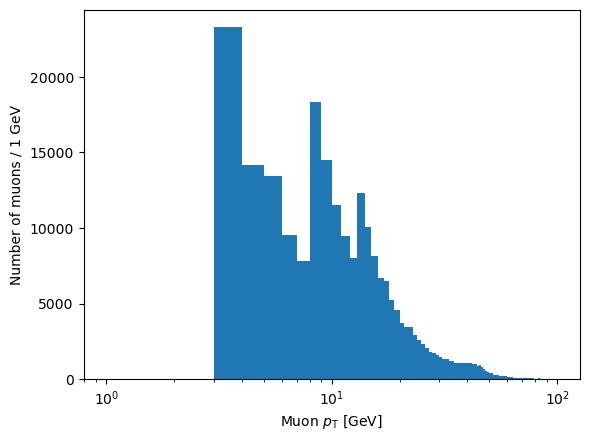

In [28]:
plt.hist(
    ak.flatten(branches["Muon_pt"]),
    bins=100,
    range=(0,100)
)
plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of muons / 1 GeV')
# Sometimes it might be a bit more insightful to use logarithmic axis.
# plt.yscale('log')
plt.xscale("log")
plt.show()

- To fix this, we can use `np.logpsace`.

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/var/folders/t8/8pnmh4rj2lbbd7gfq8tf09180000gn/T/ipykernel_31287/214470302.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')


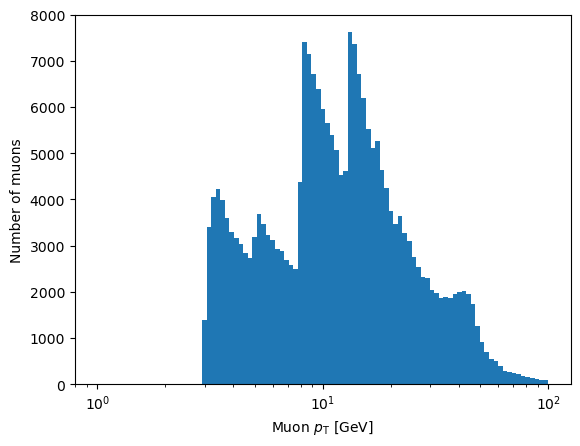

In [31]:
plt.hist(
    ak.flatten(branches['Muon_pt']),
    bins=np.logspace(
        np.log10(1), 
        np.log10(100), 
        100
    ) # plt will use the values of this array to set the bin edges
)
plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')
plt.xscale('log')
plt.ylabel('Number of muons')
plt.show()

**Exercise:** Make a histogram of the eta of all muons.

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
/var/folders/t8/8pnmh4rj2lbbd7gfq8tf09180000gn/T/ipykernel_31287/3928687615.py:3: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Muon $\eta$')


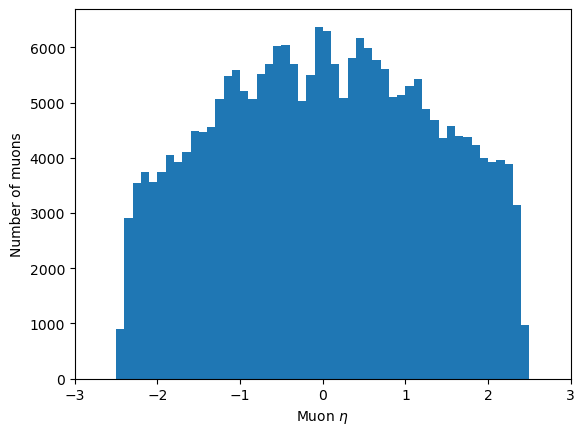

In [63]:
# Place your answer here
plt.hist(ak.flatten(branches['Muon_eta']), bins=50, range=(-2.5, 2.5))
plt.xlabel('Muon $\eta$')
plt.ylabel('Number of muons')
plt.xlim(-3, 3)
plt.show()

## Columnar Analysis
- Suppose you had an array of numbers and you wanted to check if each one of them is greater than, for instance, 25. If you are new to programming, you might think that the best way to do this might be by looping over each one of the elements. That works, but it is slow!
- Packages like numpy (on which awkward and a whole host of packages) allows us to do *vectorized* operations.
  
![vectorized_operations](./assets/vectorized.png)

- Doing this this way is better in two primary ways:
  - Higher performance
  - Cleaner syntax
- Here's an example. Suppose we want to see how many events have above 2 muons. We can do it two ways. You be the judge of which one is better for tackling this problem!

In [50]:
%%timeit
# Approach 1: Loops
GT2Muons = []
for nMuonsInEvent in branches["nMuon"]:
    GT2Muons.append(nMuonsInEvent > 0)

nEventsGT2Muons = sum(GT2Muons)
# print("Total number of events: ", len(GT2Muons))
# print("Total number of events with nMuon > 2: ", nEventsGT2Muons)

184 ms ± 2.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
%%timeit
# Approach 2: Vectorized operations
GT2Muons = branches["nMuon"] > 2
nEventsGT2Muons.sum()

145 µs ± 639 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


- As you can see, the syntax is more straight-forward (it could've been done in a single line!), and the code is run *much* faster!
- A vectorized approach also allows you to easily filter out events which don't meet some criteria defined by a "mask" (i.e. array of booleans). For instance, suppose we want to plot the $\eta$ for all muons which belong to an event which has only 1 muon.

In [52]:
single_muon_mask = branches["nMuon"] == 1
single_muon_mask

<Array [False, False, True, ..., False, False, False] type='100000 * bool'>

In [53]:
muonEta_single = branches["Muon_eta"][single_muon_mask]
muonEta_single

<Array [[2.21], [1.19], ..., [-0.723], [1.12]] type='13447 * var * float32'>

<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
/var/folders/t8/8pnmh4rj2lbbd7gfq8tf09180000gn/T/ipykernel_31287/4012836093.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Muon $\eta$')


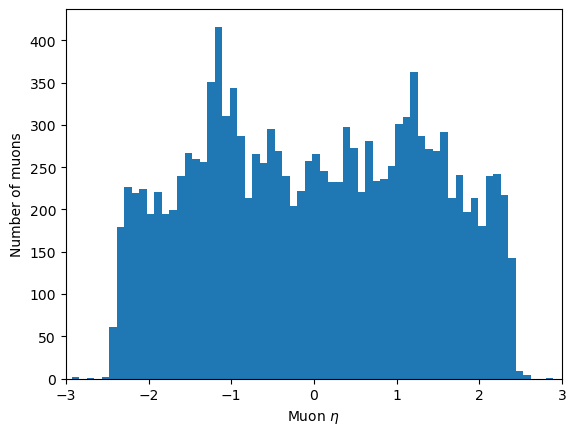

In [62]:
plt.hist(
    ak.flatten(muonEta_single),
    bins=100
)
plt.xlabel('Muon $\eta$')
plt.ylabel('Number of muons')
plt.xlim(-3, 3)
plt.show()

- As another example, suppose we want to plot all of the muons which have $|\eta| < 2$. This can be done by applying the `abs` function to the array as a whole as follows.

In [64]:
eta_mask = abs(branches["Muon_eta"]) < 2
eta_mask

<Array [[True, True], ..., [True, True, True]] type='100000 * var * bool'>

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
/var/folders/t8/8pnmh4rj2lbbd7gfq8tf09180000gn/T/ipykernel_31287/3354856832.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Muon $\eta$')


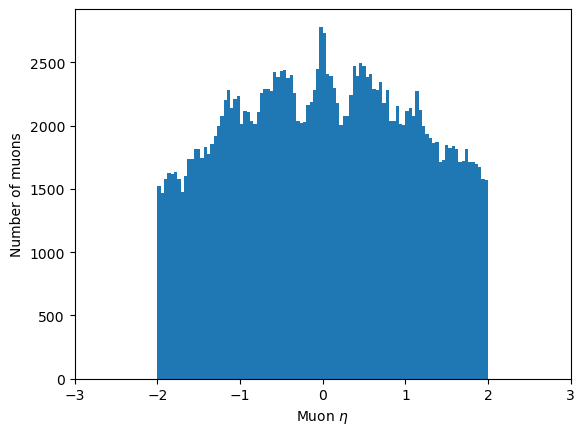

In [65]:
# Applying this mask and plotting eta
plt.hist(
    ak.flatten(branches["Muon_eta"][eta_mask]),
    bins=100
)
plt.xlabel('Muon $\eta$')
plt.ylabel('Number of muons')
plt.xlim(-3, 3)
plt.show()

- You can see that we have effectively sliced our plot such that there are zero entries beyond $|\eta| < 2$.
- Another operation which is very useful is the NOT operation. This can be applied to a whole mask all at once using the `~` operator. For instance:

In [66]:
single_muon_mask

<Array [False, False, True, ..., False, False, False] type='100000 * bool'>

In [67]:
~single_muon_mask

<Array [True, True, False, True, ..., True, True, True] type='100000 * bool'>

- You can also do the AND or OR operation between to masks. Keep in mind that the dimensions need to be the same in order for this to be possible, as the AND/OR operator requires two inputs.

In [76]:
# AND
single_muon_mask & eta_mask

<Array [[False, False], ..., [False, ..., False]] type='100000 * var * bool'>

In [72]:
# OR
single_muon_mask | eta_mask

<Array [[True, True], ..., [True, True, True]] type='100000 * var * bool'>

- Keep in mind that you need to be careful about performing a series of these operations, as the order of operations might be different from what you might expect. Just keep in mind that `&` and `|` has a higher precedence than `==`. Or, you can just make things unambigous for yourself by using parenthesis around the operations which you want to be performed first. E.g.

In [81]:
# Intended
(False == False) & False

False

In [85]:
# Not what we intended
False == False & False

True

- Now that we know how to apply masks, lets combine this with our knowledge of histograms and compare plots when we apply differing selections.

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/var/folders/t8/8pnmh4rj2lbbd7gfq8tf09180000gn/T/ipykernel_31287/2004495726.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')


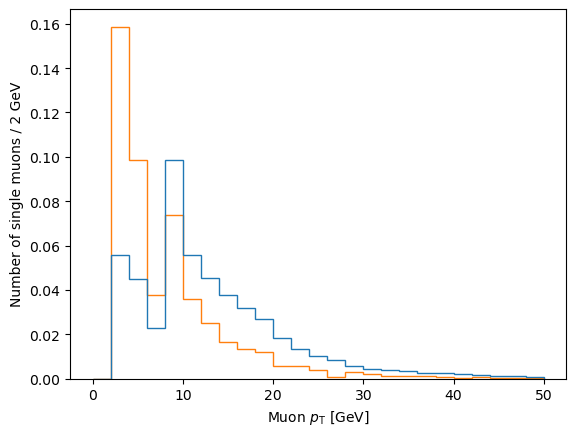

In [98]:
plt.hist(
    [ak.flatten(branches['Muon_pt'][single_muon_mask & eta_mask]),
    ak.flatten(branches['Muon_pt'][single_muon_mask & ~eta_mask])],
    bins=25, 
    range=(0, 50),
    histtype="step",
    density=True # Option which normalizes the integral of each historgram
)
plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of single muons / 2 GeV')
plt.show()

## Getting Physics-Related Information
- Let's use what we have learned so far to get some physical insight into our data.
- Many mesons and bosons have a di-muon decay channel. For instance, $Z$ boson can decay into two muons.

![etadimuon](./assets/Zdimuon.png)

- In order for a process like this to happen, certain conditions must be met such as charge conservation and 4-momentum conservation. If we wanted to measure the mass of those particles which produce two muons, we could use this to our advantage by demanding that all events under consideration have, for instance, at least two muons and that those two muons have opposite charges.
- Let's start simple: we want events with exactly two muons

In [8]:
two_muon_mask = branches["nMuon"] == 2

- Now we want to work with the 4-momentum of the muons. For this, we can use a handy library called vector which allows us to construct 4-vectors and perform operations between them, as well as compute other derived quantities from them easily.

In [10]:
import vector

In [21]:
muon_p4 = vector.zip(
    {
        "pt": branches["Muon_pt"],
        "eta": branches["Muon_eta"],
        "phi": branches["Muon_phi"],
        "mass": branches["Muon_mass"]
    }
)

In [22]:
muon_p4

<MomentumArray4D [[{rho: 10.8, phi: ..., ...}, ...], ...] type='100000 * va...'>

- We now apply the mask to keep only those events with exactly two muons.

In [23]:
two_muons_p4 = muon_p4[two_muon_mask]
two_muons_p4

<MomentumArray4D [[{rho: 10.8, phi: ..., ...}, ...], ...] type='48976 * var...'>

In [24]:
type(muon_p4)

vector.backends.awkward.MomentumArray4D

- Note that from this type of object we can obtain quantities that are derived from the inputs we gave it as we were declaring it.

In [26]:
two_muons_p4.pt

<Array [[10.8, 15.7], [...], ..., [3.31, 15.7]] type='48976 * var * float32'>

In [27]:
two_muons_p4.E

<Array [[17.5, 18.3], [...], ..., [8.82, 17.5]] type='48976 * var * float32'>

- Because what we want is to find the invariant mass of the two muons in each event, we sum the 4-momentum of both muons in each event together. 

In [42]:
sum_p4 = two_muons_p4[:, 0] + two_muons_p4[:, 1]
sum_p4 # Also a 4-momentum object

<MomentumArray4D [{rho: 8.79, phi: 1.83, ...}, ...] type='48976 * Momentum4...'>

- This gives us the invariant mass already.

In [43]:
sum_p4.mass

<Array [34.4, 27.9, 114, 1.59, ..., 36.9, 91.5, 16.5] type='48976 * float32'>

- But not so fast... How do we know that charge conservation is not being violated? For that, we can create a mask from `branch["Muon_charge]` which ensure the charges are opposite between the two muons!

In [71]:
# We get only those events with two muons
two_muon_events_q = branches["Muon_charge"][two_muon_mask]

# We make sure those two muons have opposite charges
opposite_sign_muons_mask = ((two_muon_events_q[:, 0] + two_muon_events_q[:, 1]) == 0)
opposite_sign_muons_mask

<Array [False, True, True, True, ..., False, True, True] type='48976 * bool'>

In [72]:
dimuon_p4 = sum_p4[opposite_sign_muons_mask]

- We finally have our invariant masses (from dimuon events with opposite charges)! We could have done more to clean up the events, but this is already enough to get some interesting results. Lets plot a histogram of the invariant masses and see what we get!

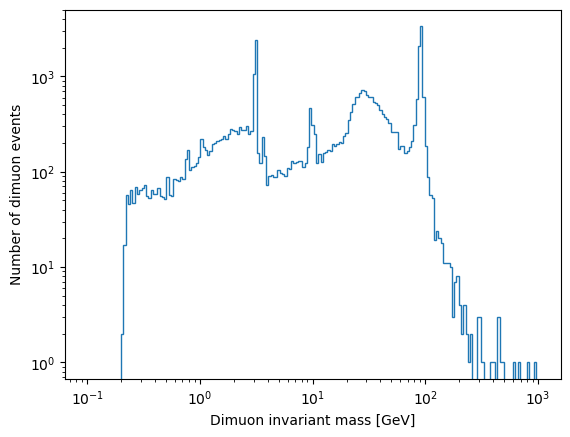

In [73]:
plt.hist(
    dimuon_p4.mass, 
    histtype="step", 
    bins=np.logspace(
        np.log10(0.1), 
        np.log10(1000), 
        200)
    )
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Dimuon invariant mass [GeV]')
plt.ylabel('Number of dimuon events')
plt.show()

- In this plot, we can see some see peaks corresponding to particles which decay into two muons.

![dimuonspectrumplt](./assets/dimuonspectrumplt.png)

We can compute $\Delta R$ which is a measure of the distance of two particles in the detector's pseudoriapidity-azimuthal angle space. It is defined as
$$
    \Delta R = \sqrt{(\Delta \eta)^2 + (\Delta \phi)^2}
$$
If two muons are produced by the same physical process, we would expect them to be close to each other and thus have a small $\Delta R$. However, if we plot the $\Delta R$ of the muons we obtained, we get the following.

In [83]:
two_muons_p4_oppq = two_muons_p4[opposite_sign_muons_mask]
two_muons_p4_oppq[0]

<MomentumArray4D [{rho: 10.5, phi: -0.275, ...}, ...] type='2 * Momentum4D[...'>

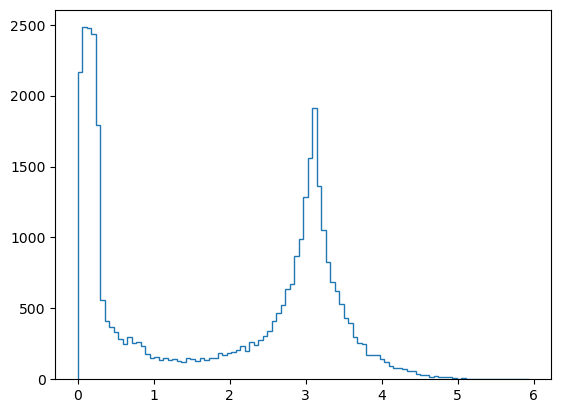

In [85]:
plt.hist(
    two_muons_p4_oppq[:,0].deltaR(two_muons_p4_oppq[:,1]),
    bins=100,
    histtype="step"
)
plt.show()

From this plot, it is evident that our data is clearly contaminated. 

**Exercise:** Clean up the data even further and plot the mass spectrum once again.

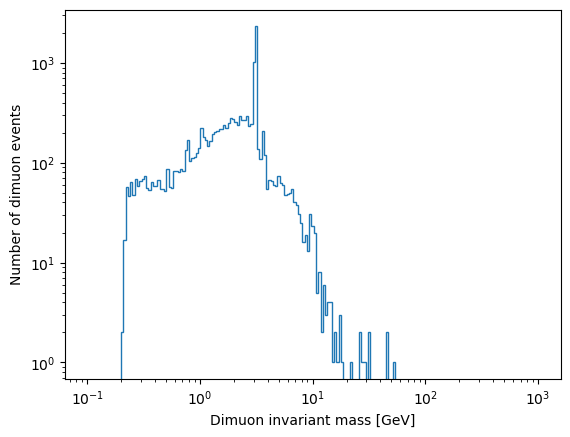

In [88]:
# Your answer here
close_muons = two_muons_p4_oppq[:,0].deltaR(two_muons_p4_oppq[:,1]) < 0.5
dimuon_p4_close = dimuon_p4[close_muons]

plt.hist(
    dimuon_p4_close.mass, 
    histtype="step", 
    bins=np.logspace(
        np.log10(0.1), 
        np.log10(1000), 
        200)
    )
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Dimuon invariant mass [GeV]')
plt.ylabel('Number of dimuon events')
plt.show()

Answer: 
1. Can you still see each of the peaks? If no, why do you think that is? 
2. Did we suppress any of the peaks that were visible before? What does that tell us about that corresponding particle's dimuon decay channel?
3. In the $\Delta R$ plot we saw a second peak at ~3. What do you think this peak corresponds to? Plot the mass spectrum histogram again, but considering only dimuons that are far away.

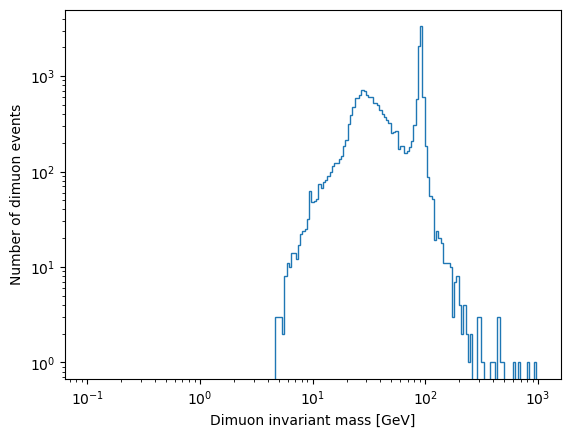

In [89]:
# Your answer here
close_muons = two_muons_p4_oppq[:,0].deltaR(two_muons_p4_oppq[:,1]) > 1.5
dimuon_p4_far = dimuon_p4[close_muons]

plt.hist(
    dimuon_p4_far.mass, 
    histtype="step", 
    bins=np.logspace(
        np.log10(0.1), 
        np.log10(1000), 
        200)
    )
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Dimuon invariant mass [GeV]')
plt.ylabel('Number of dimuon events')
plt.show()